# Usage Guide : pygtm
## transition matrix

In [1]:
import sys
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cmocean
import cartopy.feature as cfeature
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline

In [2]:
sys.path.insert(0, '../')
from pygtm.physical import physical_space
from pygtm.matrix import matrix_space
from pygtm.dataset import trajectory

# Load drifter trajectories
## Using the drogued drifters in GDP database in the North Atlantic ([*download* data here](https://miamiedu-my.sharepoint.com/:u:/g/personal/pxm498_miami_edu/EfaPVkKsPABJrJtKyctKrAUBpp7XzNHHrOLUhFow3pMkZw?e=MXzrcG)) and ([notebook](https://github.com/philippemiron/notebooks/blob/master/gdp.ipynb) for more info)

In [3]:
filename = 'data/gdp-north-atlantic-drogued.mat'
with h5py.File(filename, 'r') as f:
    d_id = f['id'][0]
    x = f['x'][0]  # [deg]
    y = f['y'][0]  # [deg]
    t = f['t'][0]  # [day]
del f

# drifter IDs are reused in the GDP so you make sure
# there isn't more than 10d before data points of a
# same drifter ID
I = np.where(abs(np.diff(d_id, axis=0)) > 0)[0]
I = np.insert(I, [0, len(I)], [-1, len(d_id) - 1])
max_id = np.max(d_id)

for i in range(0, len(I) - 1):
    range_i = np.arange(I[i] + 1, I[i + 1] + 1)
    t_diff = np.diff(t[range_i])

    # if there is a big gap, I changed the id and
    # treat the new segments as another drifters
    jump = np.where(t_diff > 10)[0]  # 10 days
    if len(jump) > 0:
        jump = np.insert(jump, [0, len(jump)], [-1, len(range_i) - 1])

        for j in range(0, len(jump) - 1):
            range_j = np.arange(jump[j] + 1, jump[j + 1] + 1)
            d_id[range_i[range_j]] = np.ones(len(range_j)) * (max_id + 1)  # range modification
            max_id += 1

# Parameters
- T: Transition time [day]
- spatial_dis : number of bin in the the meridional direction (the number in the zonal direction is fixed to have almost square bin)
- lon : min and max longitude value of the initial domain
- lat : min and max latitude value of the initial domain

In [4]:
T = 5  # transition time [days]
spatial_dis = 40
lon = [-98, 35]
lat = [-5, 80]

# create the grid and bins
d = physical_space(lon, lat, spatial_dis)

# creates segments ready to plot with add_collection()
data = trajectory(x,y,t,d_id)

# Next step creates the trajectories segment
- total of len(data.x0) segments
- data.x0, data.y0: initial lon, lat of a segment (at t0)
- data.xt, data.yt: final lon, lat of a segment (t0 + T)
- the time difference between (x0, y0) and (xT, yT) is the transition time T

In [5]:
data.create_segments(T)

In [6]:
# the trajectory is interpolated daily
print(data.x0[0:6])
# and as you can see from x0 and xT, x0[6] is equal to xT[0] which means 
# that x0[0] and xT[0] are T days apart
print(data.xt[0:6])

[-82.103 -82.248 -82.343 -80.06  -80.114 -80.229]
[-82.534 -82.655 -82.678 -80.398 -80.334 -80.407]


# Create the matrix object and fill the transition matrix

- N : number of bin in the domain after removing empty bin (land or no data)
- B [N] : list of list of particle at the initial time in each bin
- M [N] : number of particles per bins at time t
- P [N,N]: 
- eigL [Nv] : eigenvalues (real eigenvalues in decreasing order)
- eigR [Nv] : eigenvalues 
- L [N, Nv] : left eigenvectors
- R [N, Nv] : right eigenvectors
- fi [N] : flow inside of the domain
- fo [N] : flow outisde of the domain

In [7]:
# create matrix object
tm = matrix_space(d)
tm.fill_transition_matrix(data)

Domain contains 551 bins. (385 bins were removed)


In [8]:
# calculate the eigenvectors of the transition matrix
# this takes the most time, only do if you want to look
# at the eigenstructures or calculate the lagrangian geography
tm.left_and_right_eigenvectors(100)

In [9]:
# asked for 100 vectors but we keep only the real one (44 in this case)
tm.R.shape

(551, 32)

# Plotting the vector fi and fo to visualize where drifters gets in and out of the domain. Those vectors are probability distribution, so the sum(fi)=sum(fo)=1.

In [10]:
# simple function to fix the axis and make plot prettier
def geo_map(ax):
    # ticks
    ax.set_xticks([-90, -60, -30, 0, 30], crs=ccrs.PlateCarree())
    ax.set_yticks([-10, 20, 50, 80], crs=ccrs.PlateCarree())
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())

    # add land and coastline
    ax.add_feature(cfeature.LAND, facecolor='grey', zorder=1)
    ax.add_feature(cfeature.COASTLINE, linewidth=0.25, zorder=1)

/Users/pmiron/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/Users/pmiron/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


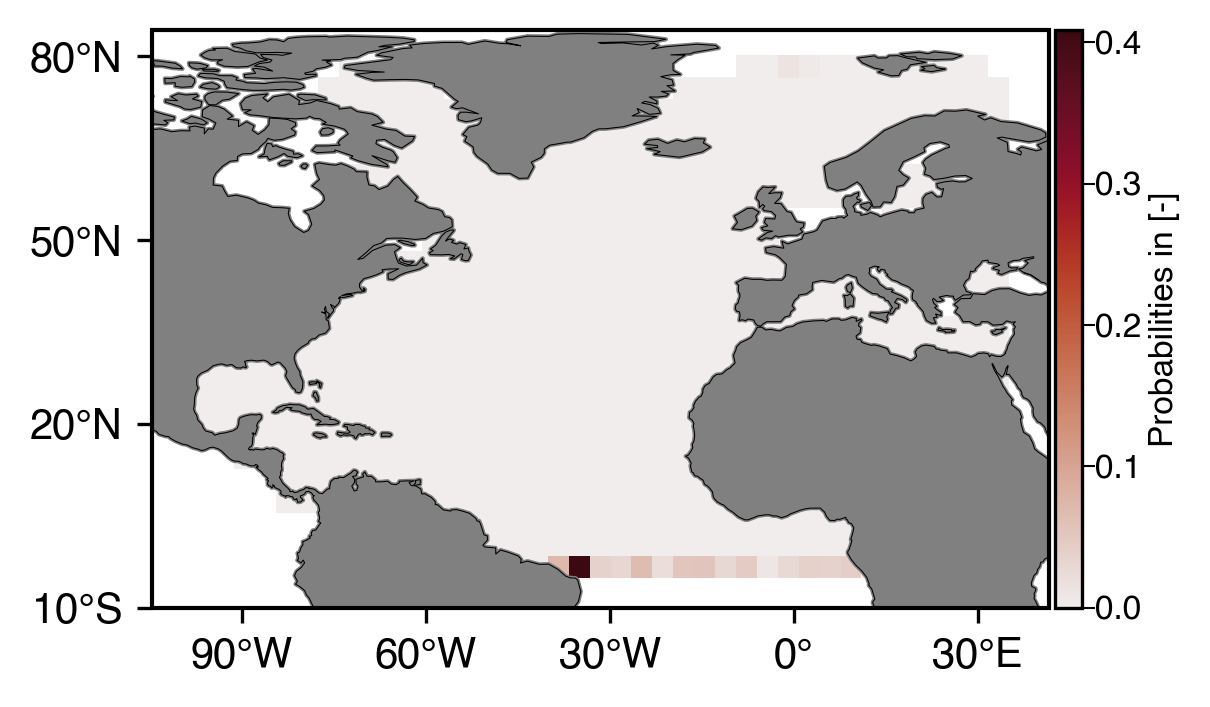

In [11]:
# flow in and out
fig = plt.figure(figsize=(4, 4), dpi=300)
ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')
p1 = ax1.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.fi), cmap=cmocean.cm.amp, transform=ccrs.PlateCarree())
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p1, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label('Probabilities in [-]', size=8, labelpad=2)
geo_map(ax1)

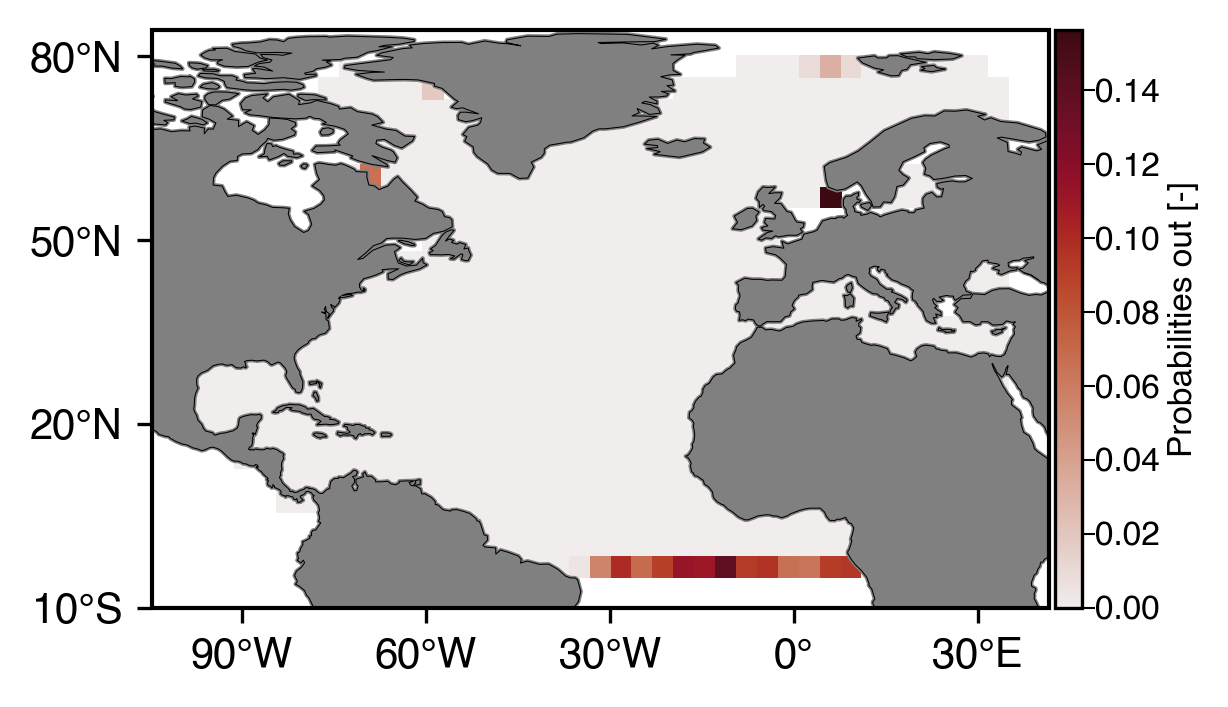

In [12]:
fig = plt.figure(figsize=(4, 4), dpi=300)
ax2 = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(), aspect='equal')
p2 = ax2.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.fo), cmap=cmocean.cm.amp, transform=ccrs.PlateCarree())
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="3%", pad=0.02, axes_class=plt.Axes)
cb = fig.colorbar(p2, cax=cax)
cb.ax.tick_params(which='major', labelsize=8, length=3, width=0.5, pad=0.05)
cb.set_label('Probabilities out [-]', size=8, labelpad=2)
geo_map(ax2)

# Eigenvalues

In [13]:
multiplicity = np.where(tm.eigL-1<-1e-11)[0][0]
print('There is %d groups of connected components. We should expect %d eigenvalues equal to 1.' % (multiplicity,multiplicity))

There is 6 groups of connected components. We should expect 6 eigenvalues equal to 1.


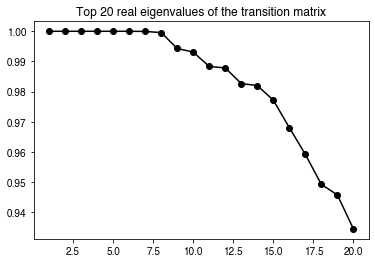

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title('Top 20 real eigenvalues of the transition matrix')
ax.plot(np.arange(0,20)+1, tm.eigL[0:20], marker='o', color='k');

# Eigenvectors

/Users/pmiron/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/Users/pmiron/miniconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


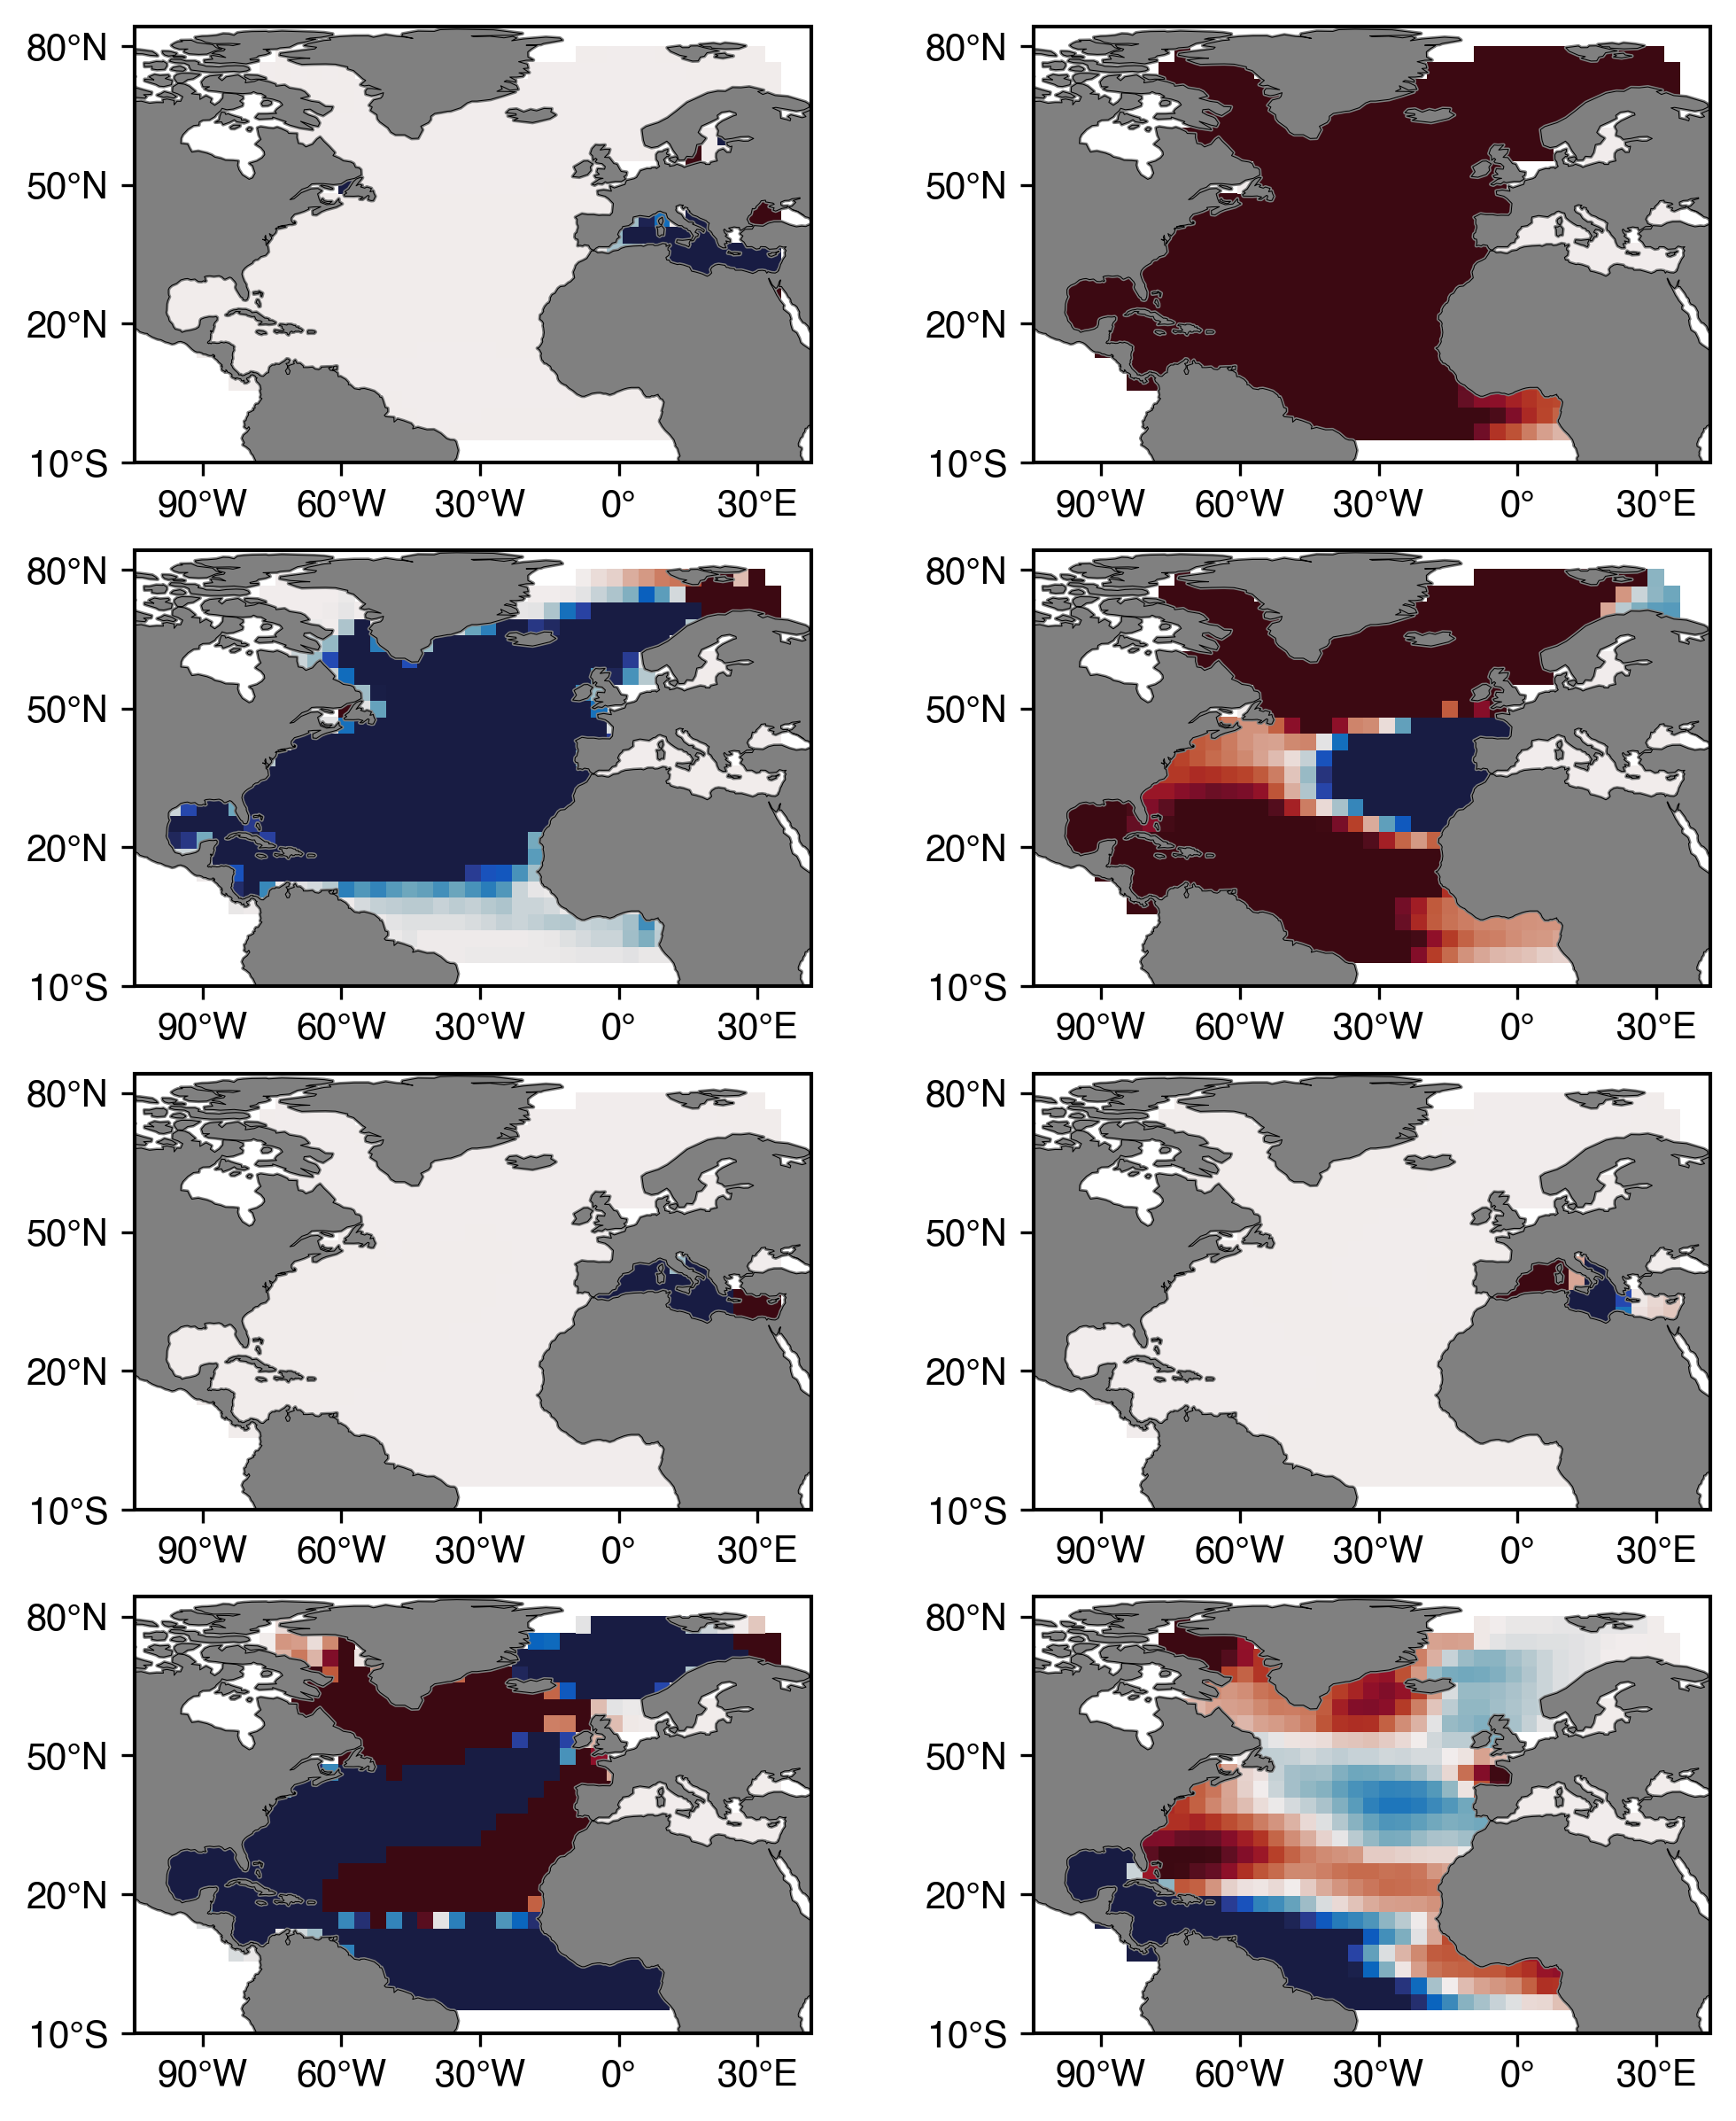

In [15]:
fig = plt.figure(figsize=(8, 10), dpi=300)
ax1 = fig.add_subplot(421, projection=ccrs.PlateCarree(), aspect='equal')
ax2 = fig.add_subplot(422, projection=ccrs.PlateCarree(), aspect='equal')
ax3 = fig.add_subplot(423, projection=ccrs.PlateCarree(), aspect='equal')
ax4 = fig.add_subplot(424, projection=ccrs.PlateCarree(), aspect='equal')
ax5 = fig.add_subplot(425, projection=ccrs.PlateCarree(), aspect='equal')
ax6 = fig.add_subplot(426, projection=ccrs.PlateCarree(), aspect='equal')
ax7 = fig.add_subplot(427, projection=ccrs.PlateCarree(), aspect='equal')
ax8 = fig.add_subplot(428, projection=ccrs.PlateCarree(), aspect='equal')
axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8]

for i, ax in enumerate(axes):
    if i % 2 == 0:
        pcm = ax.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.L[:, multiplicity-1+i]), cmap=cmocean.cm.balance,
                            transform=ccrs.PlateCarree(), vmin=-1e-03, vmax=1e-03)
    else:
        pcm = ax.pcolormesh(d.vx, d.vy, d.vector_to_matrix(tm.R[:, multiplicity-1+i]), cmap=cmocean.cm.balance, 
                            transform=ccrs.PlateCarree(), vmin=-1e-01, vmax=1e-01)
    geo_map(ax)    